In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### 1.	Load titanic dataset

In [31]:
# download dataset from given link and rename titanic.csv to Titanic dataset.csv
# https://data.world/xprizeai-ai/titanic-disaster-dataset
data=pd.read_csv('/content/Titanic dataset.csv')
data=data.iloc[:-1,:-3]
data.shape

(1309, 11)

#### 2.	Do the exploratory analysis of the dataset 


In [9]:
print('Shape: ',data.shape)
#Dataset comprises of 1309 observations and 11 characteristics (10 independant and 1 dependant)

Shape:  (1309, 11)


In [32]:
data.info()
# Data has 6 columns of float dtype, 5 of object(string) dtype
# age, fare, cabin, embarked columns have null/missing values.
# cabin has too many missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1046 non-null   float64
 5   sibsp     1309 non-null   float64
 6   parch     1309 non-null   float64
 7   ticket    1309 non-null   object 
 8   fare      1308 non-null   float64
 9   cabin     295 non-null    object 
 10  embarked  1307 non-null   object 
dtypes: float64(6), object(5)
memory usage: 112.6+ KB


In [ ]:
# making a list of columns with only integer and float values
numeric_columns = ['pclass','survived','age','sibsp','parch','fare']

In [ ]:
data[numeric_columns].describe()
# There is a large difference between 75th %tile and max values of 'age','fare' implies that the outliers have notably larger values

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


#####	Perform univariate analysis by plotting various charts 


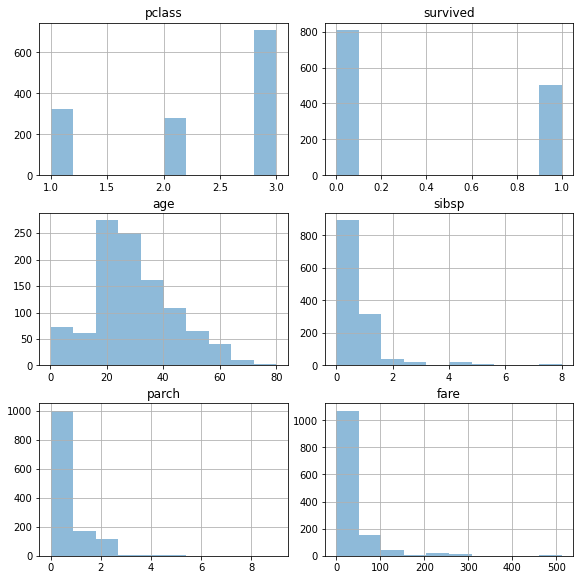

In [ ]:
# histograms
data[numeric_columns].hist(alpha=0.5,figsize=(8,8))
plt.tight_layout(pad=0.5)
plt.show()

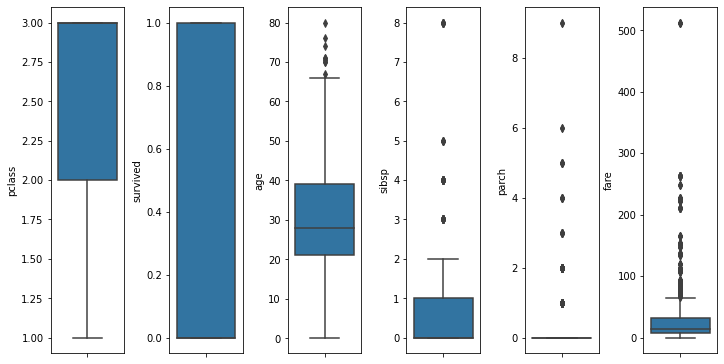

In [ ]:
# boxplots
# box plots to view distribution of values across their range and identify which columns have outliers
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(10, 5))
axs = axs.flatten()
i = 0
for c in numeric_columns:
    sns.boxplot(y=c, data=data, ax=axs[i])
    i += 1
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
# age, sibsp, parch, fare columns have a lot of outliers

##### Perform multivariate analysis 


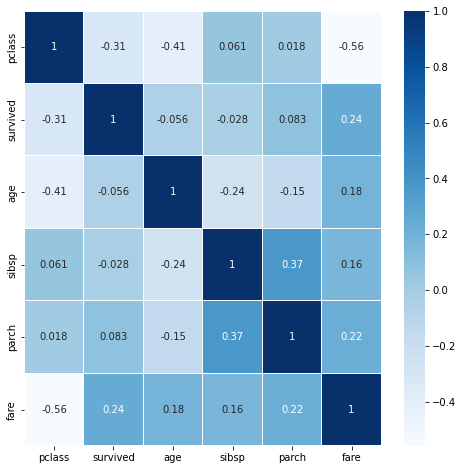

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(data=data.corr(),cmap='Blues',annot=True,linewidths=0.2)
# no 2 columns are highly correlated

#### 3.	Impute the missing values and remove any undesirable feature from the dataset.

In [ ]:
# splitting features and target variable
X = pd.concat([data.iloc[:,0],data.iloc[:,2:]],axis=1)
y = data.iloc[:,1]

In [ ]:
# Imputing missing values using most_frequent strategy
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
X = pd.DataFrame(imp.fit_transform(X),columns=X.columns)

In [ ]:
# 'name' column is unique to almost each row and does not contribute anything to the classification model
# 'cabin' column has too many null values
X = X.drop(['name','cabin'],axis=1)

In [ ]:
# Label Encoding ticket column
from sklearn.preprocessing import LabelEncoder
X['ticket']=pd.DataFrame(LabelEncoder().fit_transform(X['ticket']))

# One Hot Encoding categorical columns (pclass, sex, embarked)
for i in ['pclass','sex','embarked']:
  temp = pd.get_dummies(X[i],prefix=i)
  t = X.columns.get_loc(i)
  X = X.drop(labels=i,axis=1)
  for i in range(temp.shape[1]-1,-1,-1):
    X.insert(t, temp.columns[i], temp.iloc[:,i],False)

In [ ]:
# Normalising Data
from sklearn.preprocessing import MinMaxScaler
X = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns)

#### 4.	Check for the outliers in the columns and treat the outliers if present.

In [ ]:
# checking outliers by using skewness from normal distribution
col=[]
skew = X.skew()
for c in X.columns:
  if abs(skew[c])>1:
    col.append(c)
print(col)

['pclass_1', 'pclass_2', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q']


In [ ]:
# treating outliers by log transforming all columns with skewness
eps=1e-7
for c in col:
    X[c] = np.maximum(np.full(X[c].shape, eps), np.minimum(np.full(X[c].shape, 1-eps), X[c]))
    X[c] = np.log10(X[c])

#### 5.	Split the dataset into train and test. 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### 6.	Construct Naïve Bayes model 

In [ ]:
# Construct Naive Bayes model to predict the survival of a person  
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
# compare the results for train and test subsets using accuracy, precision, recall, f1 score. 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from numpy import mean

train_a = accuracy_score(y_train,y_train_pred)
train_p, train_r, train_f1, support = precision_recall_fscore_support(y_train,y_train_pred)
train_scores = [train_a,mean(train_p),mean(train_r),mean(train_f1)]

test_a = accuracy_score(y_test,y_test_pred)
test_p, test_r, test_f1, support = precision_recall_fscore_support(y_test,y_test_pred)
test_scores = [test_a,mean(test_p),mean(test_r),mean(test_f1)] 

def print_all(s):
  print('Accuracy: ',s[0])
  print('Precision: ',s[1])
  print('Recall: ',s[2])
  print('F1 Score: ',s[3])

print('Training Model')
print_all(train_scores)

print('\nTesting Model')
print_all(test_scores)


Training Model
Accuracy:  0.7716615698267074
Precision:  0.7593703435650729
Recall:  0.7686410857908847
F1 Score:  0.7624676795890659

Testing Model
Accuracy:  0.7560975609756098
Precision:  0.7441433867084495
Recall:  0.7502644259019862
F1 Score:  0.7464440321583179


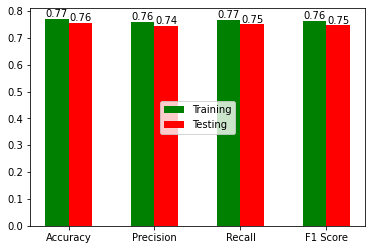

In [ ]:
ind = np.arange(len(train_scores))
width = 0.27

ax = plt.figure().add_subplot(111)
rects1 = ax.bar(ind-(width/2), train_scores, width, color='g')
rects2 = ax.bar(ind+(width/2), test_scores, width, color='r')

ax.set_xticks(ind)
ax.set_xticklabels(['Accuracy','Precision','Recall','F1 Score'])
ax.legend((rects1[0], rects2[0]), ('Training', 'Testing'),loc='center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%.2f'%h, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

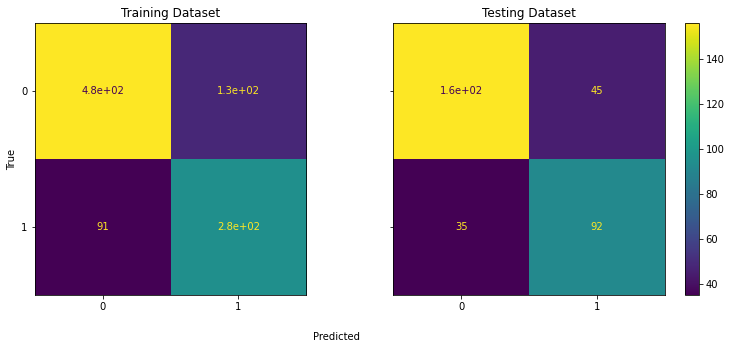

In [ ]:
# Also check the values in confusion matrix.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

cm = confusion_matrix(y_train, y_train_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=axes[0])
disp.ax_.set_title('Training Dataset')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('True')

cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=axes[1])
disp.ax_.set_title('Testing Dataset')
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

f.text(0.5, 0, 'Predicted', ha='left')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

#### 7.	Look for real world applications where you can apply Naïve Bayes classification model.

Sentiment Analysis

One of the most prominent areas of machine learning is sentiment analysis, and this algorithm is quite useful there as well. Sentiment analysis focuses on identifying whether the customers think positively or negatively about a certain topic (product or service).

Recommender Systems

With the help of Collaborative Filtering, Naive Bayes Classifier builds a powerful recommender system to predict if a user would like a particular product (or resource) or not. Amazon, Netflix, and Flipkart are prominent companies that use recommender systems to suggest products to their customers. 

Text Classification

Most of the time, Naive Bayes finds uses in-text classification due to its assumption of independence and high performance in solving multi-class problems. It enjoys a high rate of success than other algorithms due to its speed and efficiency. 